In [1]:
import json
import sys
from collections import defaultdict, Counter
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

from utils.fix_label import fix_general_label_error

EXPERIMENT_DOMAINS = ["none", "hotel", "train", "restaurant", "attraction", "taxi"]
DOMAIN_INDICES = dict()
for domain in EXPERIMENT_DOMAINS:
    DOMAIN_INDICES[domain] = len(DOMAIN_INDICES)
def get_slot_information():
    ontology = json.load(open("data/multi-woz/MULTIWOZ2.1/ontology.json", 'r'))
    ontology_domains = dict([(k, v) for k, v in ontology.items() if k.split("-")[0] in EXPERIMENT_DOMAINS])
    SLOTS = [k.replace(" ","").lower() if ("book" not in k) else k.lower() for k in ontology_domains.keys()]
    return SLOTS
ALL_SLOTS = get_slot_information()

def fix_none_typo(value):
    if value in ("not men", "not", "not mentioned", "", "not mendtioned", "fun", "art"):
        return 'none'
    else:
        return value

In [2]:
# loading data

filename = 'data/train_dials.json'
with open(filename) as fp:
    dialogue_data = json.load(fp)
    
filename = 'data/dev_dials.json'

dialogue_dev_data = dict()
with open(filename) as fp:
    for dialogue in json.load(fp):
        dialogue['dialogue'].sort(key=lambda x: int(x['turn_idx']))
        dialogue_dev_data[dialogue['dialogue_idx']] = dialogue

max_num_turn = max(max(turn['turn_idx'] for turn in dialogue['dialogue']) for dialogue in dialogue_data)
max_num_turn

21

In [3]:
# calculate distribution of slots at turns

slot_names = set()
slot_turn_pairs = Counter()
for dialogue in dialogue_data:
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        for node_key, node_value in turn['turn_label']:
            if fix_none_typo(node_value) == 'none':
                continue
            node_key = node_key.replace(' ', '-')
            slot_names.add(node_key)
            slot_turn_pairs[(node_key, turn_idx)] += 1
            
slot_names = list(slot_names)
slot_names.sort()
slot_turn_pairs

Counter({('hotel-pricerange', 0): 429,
         ('hotel-type', 0): 623,
         ('hotel-parking', 1): 350,
         ('hotel-book-day', 2): 468,
         ('hotel-book-people', 2): 459,
         ('hotel-book-stay', 2): 486,
         ('hotel-book-stay', 3): 485,
         ('train-destination', 0): 791,
         ('train-arriveby', 0): 263,
         ('train-departure', 1): 745,
         ('train-day', 2): 300,
         ('train-book-people', 3): 299,
         ('hotel-stars', 4): 262,
         ('hotel-internet', 4): 169,
         ('hotel-name', 5): 332,
         ('hotel-book-day', 6): 229,
         ('hotel-book-people', 6): 222,
         ('hotel-book-stay', 6): 253,
         ('hotel-area', 0): 471,
         ('hotel-internet', 0): 392,
         ('hotel-pricerange', 1): 459,
         ('hotel-name', 2): 445,
         ('hotel-type', 2): 259,
         ('train-departure', 5): 245,
         ('train-book-people', 6): 182,
         ('train-leaveat', 6): 81,
         ('train-destination', 6): 85,
      

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f2e04b62150>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f2e0506be50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f2e056c5190>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f2dfa4b8110>}

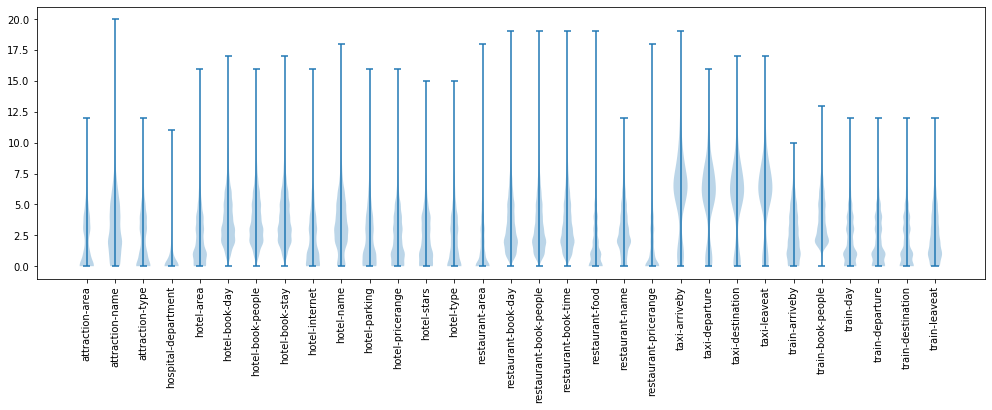

In [4]:
#slot_names_domain = [name for name in slot_names if name.startswith('restaurant-')]
slot_names_domain = slot_names
data = np.array([
    [slot_idx, turn_idx, slot_turn_pairs[(slot_names_domain[slot_idx], turn_idx)]] for slot_idx in range(len(slot_names_domain)) for turn_idx in range(max_num_turn+1)
])
x = data[:, 0]
y = data[:, 1]
s = data[:, 2]
plt.figure(figsize=(17, 5))
#plt.scatter(x, y, s)
plt.xticks(1+np.arange(len(slot_names_domain)), slot_names_domain, rotation='vertical')

violindata = [
    [turn_idx for turn_idx in range(max_num_turn+1) for _ in range(slot_turn_pairs[(slot_names_domain[slot_idx], turn_idx)])]
    for slot_idx in range(len(slot_names_domain))
]
#violindata
plt.gca().violinplot(violindata)

In [5]:
slot_indices = dict((name, idx) for idx, name in enumerate(slot_names))
slot_distribution = [[] for _ in range(len(slot_names))]
for dialogue in dialogue_data:
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        for node_key, node_value in turn['turn_label']:
            if fix_none_typo(node_value) == 'none':
                continue
            node_key = node_key.replace(' ', '-')
            slot_distribution[slot_indices[node_key]].append(turn_idx / len(dialogue['dialogue']))

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f2dfa27b410>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f2e34329450>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f2df995e8d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f2df995e350>}

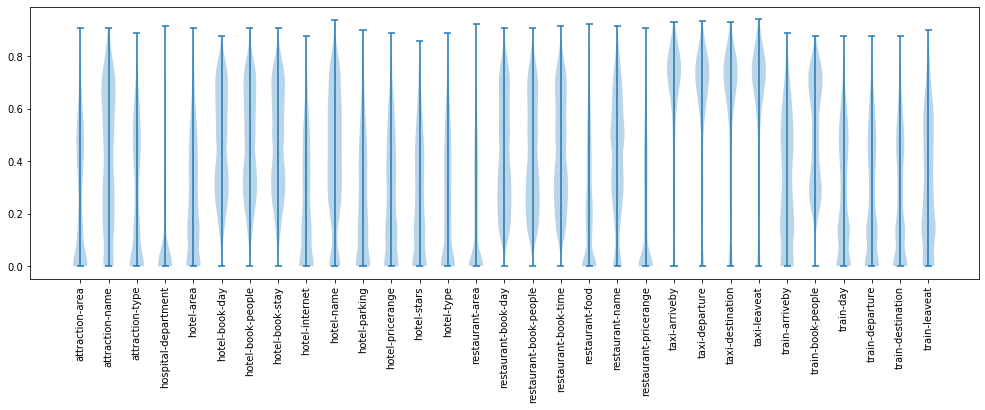

In [6]:

plt.figure(figsize=(17, 5))
#plt.scatter(x, y, s)
plt.xticks(1+np.arange(len(slot_names_domain)), slot_names_domain, rotation='vertical')
plt.gca().violinplot(slot_distribution)

In [25]:
#test_domain = 'train'
test_domain = None

def remove_none_slots(belief):
    for slot_tuple in belief:
        domain, slot_name, slot_value = slot_tuple.split('-', maxsplit=2)
        if slot_value == 'none':
            continue
            
        if test_domain is not None and domain != test_domain:
            continue
            
        yield slot_tuple

def get_joint_accuracy(turn):
    return float(set(remove_none_slots(turn['turn_belief'])) == set(remove_none_slots(turn['pred_bs_ptr'])))

def print_turn(dialogue_id, model_name, up_to=-1):
    dialogue = dialogue_dev_data[dialogue_id]
    if up_to < 0:
        up_to = len(dialogue['dialogue'])
    
    print()
    print(dialogue_id + '/' + str(up_to))
    for turn_idx in range(up_to + 1):
        if turn_idx > 0:
            print('S: ' + dialogue['dialogue'][turn_idx]['system_transcript'])
        print('U: ' + dialogue['dialogue'][turn_idx]['transcript'])
    pred_data_all[model_name][dialogue_id][str(turn_idx)]['turn_belief'].sort()
    pred_data_all[model_name][dialogue_id][str(turn_idx)]['pred_bs_ptr'].sort()
    print('Ann:', pred_data_all[model_name][dialogue_id][str(turn_idx)]['turn_belief'])
    print('Pred:', pred_data_all[model_name][dialogue_id][str(turn_idx)]['pred_bs_ptr'])
    

In [26]:
#ALL_MODELS = ['taxi2train-pct0', 'taxi2train-pct0-tr5', 'taxi2train-pct0-tr7', 'taxi2train-pct5', 'baseline21']
ALL_MODELS = ['baseline21', 'aug5', 'aug6']

pred_data_all = dict()
for modelname in ALL_MODELS:
    with open('./model-' + modelname + '/predictions/' + (test_domain if test_domain else 'full') + '/prediction_TRADE_dev.json') as fp:
        pred_data = json.load(fp)
        pred_data_all[modelname] = pred_data


In [27]:
#test_domain = 'train'
for modelname in ALL_MODELS:
    count = 0
    accuracy = 0
    
    for dialogue_id, dialogue in dialogue_dev_data.items():
        if test_domain is not None and test_domain not in dialogue['domains']:
            continue
        
        pred = pred_data_all[modelname][dialogue_id]
        
        for turn in dialogue['dialogue']:
            turn_pred = pred[str(turn['turn_idx'])]
            count += 1
            accuracy += get_joint_accuracy(turn_pred)

    print(modelname, count, accuracy, accuracy/count, sep='\t')

baseline21	7374	3716.0	0.5039327366422566
aug5	7374	3492.0	0.4735557363710334
aug6	7374	3668.0	0.4974233794412802


In [9]:
modelname = 'baseline21'

max_num_turn = max(len(dlg) for dlg in pred_data_all[modelname].values())
per_turn_count = np.zeros((max_num_turn+1,), dtype=np.int32)
per_turn_accuracy = np.zeros((max_num_turn+1,), dtype=np.int32)
per_turn_recovery = np.zeros((max_num_turn+1,), dtype=np.int32)

for dialogue_id, dialogue in dialogue_dev_data.items():
    #if test_domain not in dialogue['domains']:
    #    continue

    pred = pred_data_all[modelname][dialogue_id]

    prev_turn_ok = 0
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        turn_pred = pred[str(turn_idx)]
        per_turn_count[turn_idx] += 1
        turn_ok = get_joint_accuracy(turn_pred)
        per_turn_accuracy[turn_idx] += turn_ok
        
        if turn_ok and not prev_turn_ok:
            per_turn_recovery[turn_idx] += 1
        prev_turn_ok = turn_ok
            
data = [
    [turn_idx, per_turn_count[turn_idx], per_turn_accuracy[turn_idx],
     per_turn_accuracy[turn_idx] / per_turn_count[turn_idx],
     per_turn_recovery[turn_idx],
     per_turn_recovery[turn_idx] / per_turn_count[turn_idx],
     pow(0.96, turn_idx+1)]
    for turn_idx in range(max_num_turn)
]
pd.DataFrame(data, columns=['turn_idx', 'count', 'accurate count', 'accuracy', 'recovered count', 'recovered accuracy', 'ceiling'])

turn_idx  count  accurate count  accuracy  recovered count  \
0          0   1000             899  0.899000              899   
1          1   1000             735  0.735000               36   
2          2    997             580  0.581745               54   
3          3    959             475  0.495308               65   
4          4    892             375  0.420404               58   
5          5    811             274  0.337855               38   
6          6    656             177  0.269817               31   
7          7    475             108  0.227368               19   
8          8    280              48  0.171429                7   
9          9    153              25  0.163399                5   
10        10     85              11  0.129412                0   
11        11     36               5  0.138889                3   
12        12     16               1  0.062500                0   
13        13      8               2  0.250000                2   
14        14      3               1  0.333333                0   
15        15      2               0  0.000000                0   
16        16      1               0  0.000000                0   

    recovered accuracy   ceiling  
0             0.899000  0.960000  
1             0.036000  0.921600  
2             0.054162  0.884736  
3             0.067779  0.849347  
4             0.065022  0.815373  
5             0.046856  0.782758  
6             0.047256  0.751447  
7             0.040000  0.721390  
8             0.025000  0.692534  
9             0.032680  0.664833  
10            0.000000  0.638239  
11            0.083333  0.612710  
12            0.000000  0.588201  
13            0.250000  0.564673  
14            0.000000  0.542086  
15            0.000000  0.520403  
16            0.000000  0.499587

In [28]:
per_turn_accuracy_all = dict()
for modelname in ALL_MODELS:
    pred_data = pred_data_all[modelname]
    max_num_turn = max(len(dlg) for dlg in pred_data.values())
    per_turn_count = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_turn_accuracy = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_turn_accuracy_all[modelname] = per_turn_accuracy

    for dialogue_id, dialogue in pred_data.items():
        for turn_idx, turn in dialogue.items():
            turn_idx = int(turn_idx)
            per_turn_count[turn_idx] += 1
            per_turn_accuracy[turn_idx] += get_joint_accuracy(turn)


data = [
    ([turn_idx, per_turn_count[turn_idx]] + [
            #100 * ((per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]) - (per_turn_accuracy[turn_idx-1] / per_turn_count[turn_idx-1])
            #       if turn_idx > 0 else
            #       (per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]))
            100 * ((per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]))
            for per_turn_accuracy in per_turn_accuracy_all.values()])
    for turn_idx in range(max_num_turn)
]
pd.DataFrame(data, columns=['turn_idx', 'count']+ list(per_turn_accuracy_all.keys()))

turn_idx  count  baseline21        aug5       aug6
0          0   1000   89.900000   87.700000  89.700000
1          1   1000   73.500000   71.000000  74.600000
2          2    997   58.174524   55.967904  58.475426
3          3    959   49.530761   47.445255  48.696559
4          4    892   42.040359   37.443946  42.040359
5          5    811   33.785450   28.113440  33.538841
6          6    656   26.981707   24.390244  23.780488
7          7    475   22.736842   19.578947  20.421053
8          8    280   17.142857   15.714286  15.714286
9          9    153   16.339869   11.111111  11.764706
10        10     85   12.941176   10.588235   9.411765
11        11     36   13.888889    8.333333   8.333333
12        12     16    6.250000    6.250000   0.000000
13        13      8   25.000000   12.500000  12.500000
14        14      3   33.333333    0.000000   0.000000
15        15      2    0.000000   50.000000  50.000000
16        16      1    0.000000  100.000000   0.000000

In [29]:
per_num_slot_accuracy_all = dict()
max_num_slots = 0
for dialogue in pred_data_all['baseline21'].values():
    for turn in dialogue.values():
        max_num_slots = max(max_num_slots, len(set(remove_none_slots(turn['turn_belief']))))
max_num_slots += 1
for modelname in ALL_MODELS:
    pred_data = pred_data_all[modelname]
    per_num_slot_count = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_num_slot_accuracy = np.zeros((max_num_turn+1,), dtype=np.int32)
    per_num_slot_accuracy_all[modelname] = per_num_slot_accuracy

    for dialogue_id, dialogue in pred_data.items():
        for turn_idx, turn in dialogue.items():
            num_slot = len(set(remove_none_slots(turn['turn_belief'])))
            per_num_slot_count[num_slot] += 1
            per_num_slot_accuracy[num_slot] += get_joint_accuracy(turn)

data = [
    ([num_slot, per_num_slot_count[num_slot]] + [
            #100 * ((per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]) - (per_turn_accuracy[turn_idx-1] / per_turn_count[turn_idx-1])
            #       if turn_idx > 0 else
            #       (per_turn_accuracy[turn_idx] / per_turn_count[turn_idx]))
            100 * ((per_num_slot_accuracy[num_slot] / per_num_slot_count[num_slot]))
            for per_num_slot_accuracy in per_num_slot_accuracy_all.values()])
    for num_slot in range(max_num_slots)
]
pd.DataFrame(data, columns=['# slots', 'count']+ list(per_num_slot_accuracy_all.keys()))

# slots  count  baseline21       aug5       aug6
0         0    102   92.156863  90.196078  94.117647
1         1    530   86.792453  83.207547  86.226415
2         2    988   81.983806  77.327935  80.263158
3         3    811   58.323058  56.226880  59.679408
4         4    823   64.398542  62.697448  63.912515
5         5    642   53.115265  52.180685  54.672897
6         6    730   42.054795  40.547945  42.465753
7         7    653   38.131700  34.303216  36.140888
8         8    605   29.256198  24.628099  29.090909
9         9    478   26.150628  21.966527  24.058577
10       10    316   16.772152  12.658228  13.607595
11       11    284   18.661972  16.197183  16.549296
12       12    228   12.719298   8.771930  10.087719
13       13     99    8.080808   6.060606   9.090909
14       14     48    2.083333   4.166667   4.166667
15       15     25   24.000000   0.000000   0.000000
16       16      8    0.000000   0.000000   0.000000
17       17      4    0.000000   0.000000   0.000000

In [31]:
count = 0
accuracy_both = 0
accuracy_neither = 0
accuracy_only_baseline = 0
accuracy_only_improved = 0
max_num_slots = 0
for dialogue in pred_data_all['baseline21'].values():
    for turn in dialogue.values():
        max_num_slots = max(max_num_slots, len(set(remove_none_slots(turn['turn_belief']))))
max_num_slots += 1
max_num_turn = max(len(dlg) for dlg in pred_data_all['baseline21'].values())

per_num_slot_stats = dict()
for num_slot in range(max_num_slots):
    for turn_idx in range(max_num_turn):
        per_num_slot_stats[(num_slot, turn_idx)] = {
            'count': 0,
            'accuracy_both': 0,
            'accuracy_neither': 0,
            'accuracy_only_baseline': 0,
            'accuracy_only_improved': 0,
        }

#baseline_model = 'taxi2train-pct0-tr5'
#improved_model = 'taxi2train-pct0-tr7'
baseline_model = 'baseline21'
improved_model = 'aug6'

for dialogue_id, dialogue in dialogue_dev_data.items():
    if test_domain is not None and test_domain not in dialogue['domains']:
        continue
    
    for turn in dialogue['dialogue']:
        turn_idx = str(turn['turn_idx'])
        baseline_ok = get_joint_accuracy(pred_data_all[baseline_model][dialogue_id][turn_idx])
        improved_ok = get_joint_accuracy(pred_data_all[improved_model][dialogue_id][turn_idx])
        num_slot = len(set(remove_none_slots(pred_data_all[baseline_model][dialogue_id][turn_idx]['turn_belief'])))
        count += 1
        
        stat_key = (num_slot, turn['turn_idx'])
        per_num_slot_stats[stat_key]['count'] += 1
        
        if baseline_ok and improved_ok:
            accuracy_both += 1
            per_num_slot_stats[stat_key]['accuracy_both'] += 1
        elif baseline_ok:
            accuracy_only_baseline += 1
            per_num_slot_stats[stat_key]['accuracy_only_baseline'] += 1
        elif improved_ok:
            accuracy_only_improved += 1
            per_num_slot_stats[stat_key]['accuracy_only_improved'] += 1
        else:
            accuracy_neither += 1
            per_num_slot_stats[stat_key]['accuracy_neither'] += 1
        
print('# overall')
print('total =', count)
print('both =', accuracy_both, '(%.1f%%)' % (100* accuracy_both/count,))
print('lost =', accuracy_only_baseline, '(%.1f%%)' % (100* accuracy_only_baseline/count,))
print('gained =', accuracy_only_improved, '(%.1f%%)' % (100* accuracy_only_improved/count,))
print('neither =', accuracy_neither, '(%.1f%%)' % (100* accuracy_neither/count,))

for num_slot in range(max_num_slots):
    for turn_idx in range(max_num_turn):
        stat_key = (num_slot, turn_idx)
        count = per_num_slot_stats[stat_key]['count']
        if count == 0:
            continue
        print()
        print('# %d slots, turn %d' % (num_slot, turn_idx))
        print('total =', count)
        print('both =', per_num_slot_stats[stat_key]['accuracy_both'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_both']/count,))
        print('lost =', per_num_slot_stats[stat_key]['accuracy_only_baseline'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_only_baseline']/count,))
        print('gained =', per_num_slot_stats[stat_key]['accuracy_only_improved'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_only_improved']/count,))
        print('neither =', per_num_slot_stats[stat_key]['accuracy_neither'],
              '(%.1f%%)' % (100* per_num_slot_stats[stat_key]['accuracy_neither']/count,))

# overall
total = 7374
both = 3185 (43.2%)
lost = 531 (7.2%)
gained = 483 (6.6%)
neither = 3175 (43.1%)

# 0 slots, turn 0
total = 96
both = 89 (92.7%)
lost = 1 (1.0%)
gained = 2 (2.1%)
neither = 4 (4.2%)

# 0 slots, turn 1
total = 6
both = 4 (66.7%)
lost = 0 (0.0%)
gained = 1 (16.7%)
neither = 1 (16.7%)

# 1 slots, turn 0
total = 357
both = 320 (89.6%)
lost = 7 (2.0%)
gained = 9 (2.5%)
neither = 21 (5.9%)

# 1 slots, turn 1
total = 138
both = 100 (72.5%)
lost = 9 (6.5%)
gained = 8 (5.8%)
neither = 21 (15.2%)

# 1 slots, turn 2
total = 29
both = 16 (55.2%)
lost = 3 (10.3%)
gained = 2 (6.9%)
neither = 8 (27.6%)

# 1 slots, turn 3
total = 4
both = 1 (25.0%)
lost = 2 (50.0%)
gained = 1 (25.0%)
neither = 0 (0.0%)

# 1 slots, turn 4
total = 1
both = 0 (0.0%)
lost = 1 (100.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 1 slots, turn 5
total = 1
both = 0 (0.0%)
lost = 1 (100.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 2 slots, turn 0
total = 514
both = 455 (88.5%)
lost = 15 (2.9%)
gained = 14 (2

lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 2 (100.0%)

# 14 slots, turn 13
total = 1
both = 0 (0.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 1 (100.0%)

# 15 slots, turn 6
total = 1
both = 0 (0.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 1 (100.0%)

# 15 slots, turn 7
total = 5
both = 0 (0.0%)
lost = 2 (40.0%)
gained = 0 (0.0%)
neither = 3 (60.0%)

# 15 slots, turn 8
total = 6
both = 0 (0.0%)
lost = 1 (16.7%)
gained = 0 (0.0%)
neither = 5 (83.3%)

# 15 slots, turn 9
total = 7
both = 0 (0.0%)
lost = 1 (14.3%)
gained = 0 (0.0%)
neither = 6 (85.7%)

# 15 slots, turn 10
total = 3
both = 0 (0.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 3 (100.0%)

# 15 slots, turn 12
total = 1
both = 0 (0.0%)
lost = 0 (0.0%)
gained = 0 (0.0%)
neither = 1 (100.0%)

# 15 slots, turn 13
total = 1
both = 0 (0.0%)
lost = 1 (100.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 15 slots, turn 14
total = 1
both = 0 (0.0%)
lost = 1 (100.0%)
gained = 0 (0.0%)
neither = 0 (0.0%)

# 16 slots, turn 9
total = 3
b

In [32]:
#baseline_model = 'taxi2train-pct0-tr5'
#improved_model = 'taxi2train-pct0-tr7'
baseline_model = 'baseline21'
improved_model = 'aug6'

count = 0
for dialogue_id, dialogue in dialogue_dev_data.items():
    if test_domain is not None and test_domain not in dialogue['domains']:
        continue
    
    for turn in dialogue['dialogue']:
        turn_idx = str(turn['turn_idx'])
        num_slot = len(set(remove_none_slots(pred_data_all[baseline_model][dialogue_id][turn_idx]['turn_belief'])))
        if num_slot > 2:
            continue
        
        baseline_ok = get_joint_accuracy(pred_data_all[baseline_model][dialogue_id][turn_idx])
        improved_ok = get_joint_accuracy(pred_data_all[improved_model][dialogue_id][turn_idx])
        
        if baseline_ok and not improved_ok:
            count += 1
            print_turn(dialogue_id, improved_model, int(turn_idx))
            
print(count)


SNG0910.json/0
U: i am looking for a hotel with free parking .
Ann: ['hotel-parking-yes', 'hotel-type-hotel']
Pred: ['hotel-parking-yes']

SNG02115.json/2
U: i am looking for an afghan restaurant in the north .
S: there are no restaurant -s matching your criteria . would you like to modify your search results ?
U: how about a european food restaurant in the north , instead ?
S: we have 1 . it is the city stop restaurant . would you like me to book it for you ?
U: can you give me their phone number , address and price range , please ?
Ann: ['restaurant-area-north', 'restaurant-food-european']
Pred: ['restaurant-area-north', 'restaurant-food-european', 'restaurant-name-city stop restaurant']

SNG02115.json/3
U: i am looking for an afghan restaurant in the north .
S: there are no restaurant -s matching your criteria . would you like to modify your search results ?
U: how about a european food restaurant in the north , instead ?
S: we have 1 . it is the city stop restaurant . would you li

In [25]:
baseline_model = '21notrainfix'
improved_model = 'tr1-taxi2trainfix'
test_domain = 'train'

def has_domain(belief, domain):
    return any(slot.split('-', maxsplit=1)[0] == domain for slot in belief)

count = 0
for dialogue_id, dialogue in dialogue_dev_data.items():
    if test_domain not in dialogue['domains']:
        continue
    
    for turn in dialogue['dialogue']:
        turn_idx = turn['turn_idx']
        improved_pred = pred_data_all[improved_model][dialogue_id][str(turn_idx)]
        
        if has_domain(improved_pred['pred_bs_ptr'], 'train') and has_domain(improved_pred['pred_bs_ptr'], 'taxi'):
            print_turn(dialogue_id, improved_model, turn_idx)
            count += 1
            if count >= 100:
                break


PMUL0716.json/0
U: i need a taxi to pick us up in centre at 11:45
Ann: ['taxi-leaveat-11:45']
Pred: ['train-leaveat-11:45', 'taxi-leaveat-11:45']

PMUL4431.json/5
U: i am traveling to cambridge and looking forward to try local restaurant -s .
S: we have lots to explore ! i can help you find 1 , if you would like .
U: great ! the restaurant should serve scandinavian food and should be in the east .
S: i am sorry there are no restaurant -s serving scandinavian food . is there another type of food you might like to try ?
U: how about indian food ?
S: i have 4 different indian place -s to eat . 2 are moderate -ly priced and 2 are expensive . do you have a preference ?
U: i perfer a moderate price range . whatever you suggest . i need to book a table for 1 at 13:15 on tuesday .
S: okay , i have booked a table at the curry prince for you . the reference number is nz5wkz9v . the table will be reserved for 15 minutes .
U: thank you . could i also have information on trains that depart from ca

In [11]:
pred_data = pred_data_all['baseline21']

with open('turn1-errors.txt', 'w') as fp:
    count = 0
    for dialogue_id, dialogue in pred_data.items():
        turn = dialogue['1']
        num_considered_turns = 2

        if not get_joint_accuracy(turn):
            turn_objs = dialogue_dev_data[dialogue_id]['dialogue'][ : num_considered_turns]
            print(dialogue_id, file=fp)
            for turn_obj in turn_objs:
                if turn_obj['system_transcript']:
                    print('S:', turn_obj['system_transcript'], file=fp)
                print('U:', turn_obj['transcript'], file=fp)
            print('Ann:', json.dumps(list(sorted(turn['turn_belief']))), file=fp)
            print('Pred:', json.dumps(list(sorted(turn['pred_bs_ptr']))), file=fp)
            print(file=fp)
            count += 1
    #if count >= :
    #    break

In [9]:
def get_turn_domains(turn):
    for slot_tuple in turn['turn_belief']:
        domain, slot_name, slot_value = slot_tuple.split('-')
        yield domain


normal_count = 0
normal_accuracy = 0
trans_count = 0
trans_accuracy = 0
delayed_trans_count = 0
delayed_trans_accuracy = 0
end_normal_count = 0
end_normal_accuracy = 0
end_trans_count = 0
end_trans_accuracy = 0
transition_count = 0

for dialogue_id, dialogue in pred_data.items():
    prev_turn_domains = set()
    delayed_trans_distance = 0
    had_transition = False
    for turn_idx, turn in dialogue.items():
        turn_idx = int(turn_idx)
        #turn_id = dialogue_id + '/' + str(turn_idx)
        
        our_turn_domains = set(get_turn_domains(turn))
        our_turn_accuracy = get_joint_accuracy(turn)
        normal_count += 1
        normal_accuracy += our_turn_accuracy
        if len(prev_turn_domains) > 0:
            is_transition = False
            for dom in our_turn_domains:
                if dom not in prev_turn_domains:
                    is_transition = True
                    break
            if is_transition:
                trans_count += 1
                trans_accuracy += our_turn_accuracy
                delayed_trans_distance = 100
                had_transition = True
        if delayed_trans_distance > 0:
            delayed_trans_count += 1
            delayed_trans_accuracy += our_turn_accuracy
            delayed_trans_distance -= 1
        if had_transition:
            transition_count += 1
        prev_turn_domains = our_turn_domains
        if turn_idx == len(dialogue)-1:
            end_normal_count += 1
            end_normal_accuracy += our_turn_accuracy
            if had_transition:
                end_trans_count += 1
                end_trans_accuracy += our_turn_accuracy

assert trans_count > 0
(normal_accuracy / normal_count, trans_accuracy / trans_count, delayed_trans_accuracy / delayed_trans_count,
 end_normal_accuracy / end_normal_count, end_trans_accuracy / end_trans_count, transition_count / normal_count)

(0.38988337401681583,
 0.13725490196078433,
 0.23787878787878788,
 0.216,
 0.1390728476821192,
 0.08950366151342555)

In [10]:
def get_slot_names(belief):
    for slot_tuple in belief:
        domain, slot_name, slot_value = slot_tuple.split('-')
        if slot_value == 'none':
            continue
        yield domain + '-' + slot_name
        
def get_name_accuracy(turn):
    return float(set(get_slot_names(turn['turn_belief'])) == set(get_slot_names(turn['pred_bs_ptr'])))

count = 0
joint_accuracy = 0
name_accuracy = 0

for dialogue_id, dialogue in pred_data.items():
    for turn_idx, turn in dialogue.items():
        #turn_idx = int(turn_idx)
        count += 1
        joint_accuracy += get_joint_accuracy(turn)
        name_accuracy += get_name_accuracy(turn)

(joint_accuracy / count, name_accuracy / count)

(0.38988337401681583, 0.48576078112286414)

In [11]:
count = 0
insertions = 0
name_errors = 0
max_num_turns = max(len(dialogue) for dialogue in pred_data.values())
count_per_turn = np.zeros((max_num_turns+1,), dtype=np.int32)
name_accuracy_per_turn = np.zeros((max_num_turns+1,), dtype=np.int32)
insertions_per_turn = np.zeros((max_num_turns+1,), dtype=np.int32)

for dialogue_id, dialogue in pred_data.items():
    for turn_idx, turn in dialogue.items():
        turn_idx = int(turn_idx)
        count += 1
        count_per_turn[turn_idx] += 1
        turn_belief = set(get_slot_names(turn['turn_belief']))
        pred_bs_ptr = set(get_slot_names(turn['pred_bs_ptr']))
        
        our_name_accuracy = int(turn_belief == pred_bs_ptr)
        name_accuracy_per_turn[turn_idx] += our_name_accuracy
        name_errors += 1 - our_name_accuracy
        
        is_insertion = False
        for slot_name in pred_bs_ptr:
            if slot_name not in turn_belief:
                is_insertion = True
                break
        if is_insertion:
            insertions += 1
            insertions_per_turn[turn_idx] += 1

(insertions, name_errors, insertions/name_errors, count, insertions / count)

(2269, 3792, 0.5983649789029536, 7374, 0.3077027393544887)

0	1000	106	82
1	1000	172	146
2	997	258	174
3	959	270	219
4	892	316	221
5	811	328	207
6	656	293	183
7	475	217	133
8	280	148	65
9	153	81	41
10	85	46	27
11	36	21	11
12	16	9	6
13	8	3	4
14	3	1	1
15	2	0	2
16	1	0	1


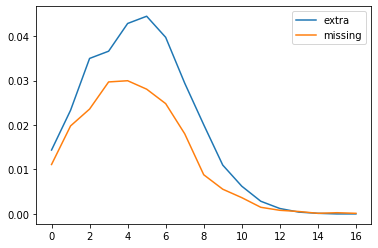

In [12]:
x = np.arange(max_num_turns)
y1 = []
y2 = []

for turn_idx in range(max_num_turns):
    print(turn_idx, count_per_turn[turn_idx], insertions_per_turn[turn_idx],
          count_per_turn[turn_idx] - name_accuracy_per_turn[turn_idx] - insertions_per_turn[turn_idx],
          sep='\t')
    
    insertion_per_turn = insertions_per_turn[turn_idx] / count_per_turn[turn_idx]
    name_error_per_turn = 1 - (name_accuracy_per_turn[turn_idx] / count_per_turn[turn_idx])
    missing_per_turn = name_error_per_turn - insertion_per_turn
    y1.append(insertions_per_turn[turn_idx] / count)
    y2.append(missing_per_turn * count_per_turn[turn_idx] / count)
    
    

plt.plot(x, y1, label='extra')
plt.plot(x, y2, label='missing')
plt.legend()